# Projet 6 : Classifiez automatiquement des biens de consommation

## Etude de faisabilité du moteur de classification

Votre mission est de réaliser une première étude de faisabilité d'un moteur de classification d'articles basé sur une image et une description pour l'automatisation de l'attribution de la catégorie de l'article.

## Contraintes

Linda vous a communiqué les contraintes suivantes :
- Afin d’extraire les features texte, il sera nécessaire de mettre en œuvre : 
- Deux approches de type “bag-of-words”, comptage simple de mots et Tf-idf
- Une approche de type word/sentence embedding classique avec Word2Vec (ou Glove ou FastText)
- Une approche de type word/sentence embedding avec BERT 
- Une approche de type word/sentence embedding avec USE (Universal Sentence Encoder).
- Afin d’extraire les features, mettre en œuvre a minima un algorithme de type SIFT / ORB / SURF.
- Un algorithme de type CNN Transfer Learning peut éventuellement être utilisé en complément, s’il peut apporter un éclairage supplémentaire à la démonstration.

In [1]:
# les libraries nécessaires :
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Standardization
from sklearn.preprocessing import StandardScaler
# ML/Clustering/PCA.
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
# Error & Quality of prediction.
from sklearn.metrics import accuracy_score, precision_score

In [2]:
# pour voir toutes les colonnes
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_row', 100)

# style de titres
font = {'family': 'Arial',
        'color':  'darkred',
        'weight': 'bold',
        'size': 15,
        }

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Téléchargement du jeux de données

In [5]:
data=pd.read_csv("/content/drive/MyDrive/flipkart_com-ecommerce_sample_1050.csv")

In [6]:
data.head(4)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."


In [7]:
data.shape

(1050, 15)

In [8]:
data.dtypes

uniq_id                     object
crawl_timestamp             object
product_url                 object
product_name                object
product_category_tree       object
pid                         object
retail_price               float64
discounted_price           float64
image                       object
is_FK_Advantage_product       bool
description                 object
product_rating              object
overall_rating              object
brand                       object
product_specifications      object
dtype: object

In [9]:
data.isna().sum()

uniq_id                      0
crawl_timestamp              0
product_url                  0
product_name                 0
product_category_tree        0
pid                          0
retail_price                 1
discounted_price             1
image                        0
is_FK_Advantage_product      0
description                  0
product_rating               0
overall_rating               0
brand                      338
product_specifications       1
dtype: int64

In [10]:
data['product_category_tree'].unique()

array(['["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]',
       '["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y..."]',
       '["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Eurospa Baby Bath Towels >> Eurospa Cotton Terry Face Towel Set (20 PIECE FA..."]',
       '["Home Furnishing >> Bed Linen >> Bedsheets >> SANTOSH ROYAL FASHION Bedsheets >> SANTOSH ROYAL FASHION Cotton Printed King sized ..."]',
       '["Home Furnishing >> Bed Linen >> Bedsheets >> Jaipur Print Bedsheets >> Jaipur Print Cotton Floral King sized Double Bed..."]',
       '["Watches >> Wrist Watches >> Maserati Time Wrist Watches"]',
       '["Watches >> Wrist Watches >> Camerii Wrist Watches"]',
       '["Watches >> Wrist Watches >> T STAR Wrist Watches"]',
       '["Watches >> Wrist Watches >> Alfajr Wrist Watches"]',
       '["Watches >> Wrist Watches >> T

In [11]:
data['product_category_tree'].nunique()

642

In [12]:
data['categorie_1'] = data['product_category_tree'].str.extract('([a-zA-Z ]+)', expand=False).str.strip()
data['categorie_1']

0       Home Furnishing
1             Baby Care
2             Baby Care
3       Home Furnishing
4       Home Furnishing
             ...       
1045          Baby Care
1046          Baby Care
1047          Baby Care
1048          Baby Care
1049          Baby Care
Name: categorie_1, Length: 1050, dtype: object

In [13]:
data['categorie_1'].nunique()

7

In [14]:
data.groupby('categorie_1').count()['uniq_id'].sort_values(ascending=False)


categorie_1
Baby Care                   150
Beauty and Personal Care    150
Computers                   150
Home Decor                  150
Home Furnishing             150
Kitchen                     150
Watches                     150
Name: uniq_id, dtype: int64

In [15]:
categories = data['product_category_tree'].str.split('>>', expand=True)
categories.head(5)

,0,1,2,3,4,5,6
0,"[""Home Furnishing",Curtains & Accessories,Curtains,Elegance Polyester Multicolor Abstract Eyelet...,None,None,None
1,"[""Baby Care",Baby Bath & Skin,Baby Bath Towels,Sathiyas Baby Bath Towels,"Sathiyas Cotton Bath Towel (3 Bath Towel, Red...",None,None
2,"[""Baby Care",Baby Bath & Skin,Baby Bath Towels,Eurospa Baby Bath Towels,Eurospa Cotton Terry Face Towel Set (20 PIECE...,None,None
3,"[""Home Furnishing",Bed Linen,Bedsheets,SANTOSH ROYAL FASHION Bedsheets,SANTOSH ROYAL FASHION Cotton Printed King siz...,None,None
4,"[""Home Furnishing",Bed Linen,Bedsheets,Jaipur Print Bedsheets,Jaipur Print Cotton Floral King sized Double ...,None,None


In [16]:
data['categorie_2'] = data['product_category_tree'].str.split('>>', expand=True)[1]
data['categorie_2']

0        Curtains & Accessories 
1              Baby Bath & Skin 
2              Baby Bath & Skin 
3                     Bed Linen 
4                     Bed Linen 
                  ...           
1045          Baby & Kids Gifts 
1046          Baby & Kids Gifts 
1047          Baby & Kids Gifts 
1048          Baby & Kids Gifts 
1049          Baby & Kids Gifts 
Name: categorie_2, Length: 1050, dtype: object

In [17]:
data['categorie_2'].nunique()

63

In [18]:
data.groupby('categorie_2').count()['uniq_id'].sort_values(ascending=False)


categorie_2
 Wrist Watches                        149
 Laptop Accessories                    87
 Infant Wear                           84
 Coffee Mugs                           74
 Showpieces                            71
 Bed Linen                             65
 Fragrances                            65
 Network Components                    49
 Cookware                              27
 Table Decor & Handicrafts             27
 Combos and Kits                       24
 Wall Decor & Clocks                   22
 Bath Linen                            21
 Curtains & Accessories                19
 Makeup                                18
 Baby & Kids Gifts                     15
 Body and Skin Care                    15
 Baby Bedding                          15
 Baby Bath & Skin                      14
 Decorative Lighting & Lamps           14
 Kitchen Tools                         14
 Kitchen & Dining Linen                14
 Containers & Bottles                  13
 Cushions, Pillows & C

In [19]:
data['product_category_tree'].str.split('>>', expand=True)[2].nunique()

246

## Visualisation des deux catégories principales en bar plots :

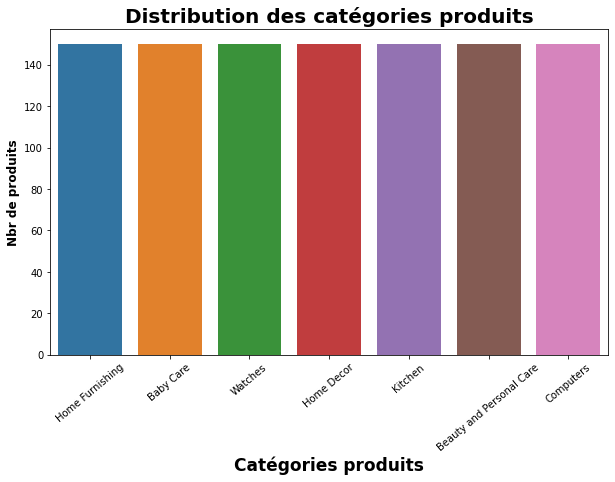

In [20]:
fig = plt.figure(figsize=(10, 6))
plt.xticks(rotation=40)
bp = sns.barplot(
    x=data['categorie_1'].value_counts().index,
    y=data['categorie_1'].value_counts(),
    data=data)
plt.title('Distribution des catégories produits', weight='bold', size=20)
plt.xlabel('Catégories produits', weight='bold', size=17)
plt.ylabel('Nbr de produits', weight='bold', size=12)
plt.show()

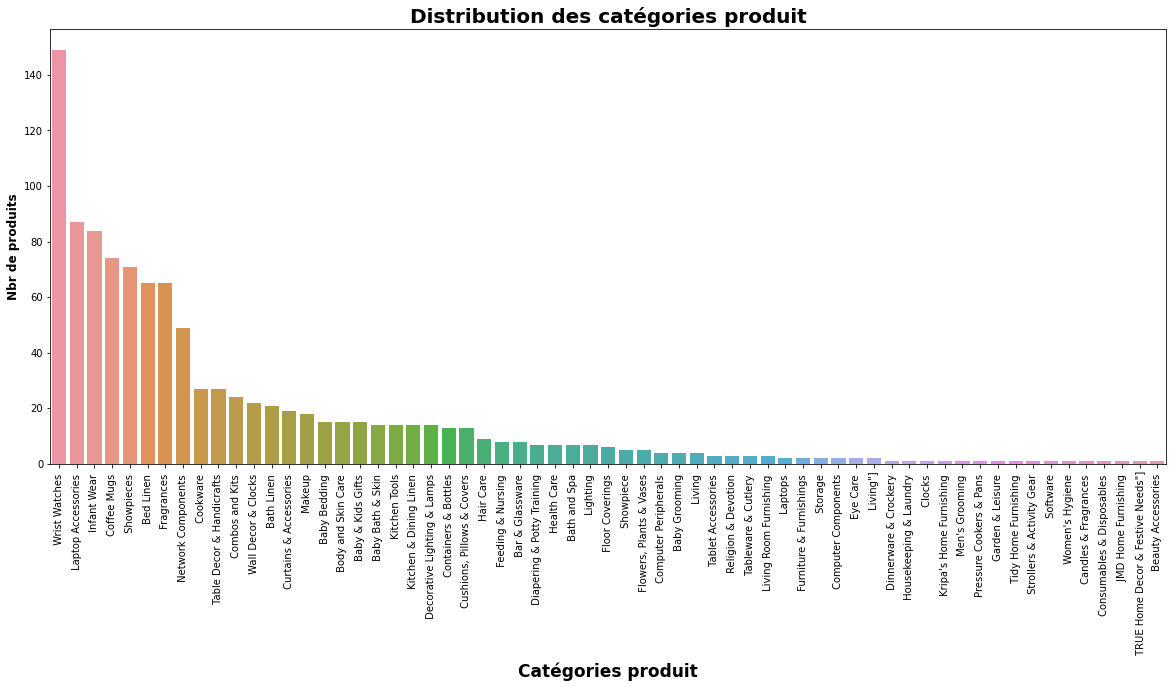

In [21]:
fig = plt.figure(figsize=(20, 8))
plt.xticks(rotation=90)
bp = sns.barplot(
    x=data['categorie_2'].value_counts().index,
    y=round(data['categorie_2'].value_counts()),
    data=data)
plt.title('Distribution des catégories produit', weight='bold', size=20)
plt.xlabel('Catégories produit', weight='bold', size=17)
plt.ylabel('Nbr de produits', weight='bold', size=12)
plt.show()

In [22]:
data['description']

0       Key Features of Elegance Polyester Multicolor ...
1       Specifications of Sathiyas Cotton Bath Towel (...
2       Key Features of Eurospa Cotton Terry Face Towe...
3       Key Features of SANTOSH ROYAL FASHION Cotton P...
4       Key Features of Jaipur Print Cotton Floral Kin...
                              ...                        
1045    Oren Empower Extra Large Self Adhesive Sticker...
1046    Wallmantra Large Vinyl Sticker Sticker (Pack o...
1047    Buy Uberlyfe Extra Large Pigmented Polyvinyl F...
1048    Buy Wallmantra Medium Vinyl Sticker Sticker fo...
1049    Buy Uberlyfe Large Vinyl Sticker for Rs.595 on...
Name: description, Length: 1050, dtype: object

In [23]:
# Check de la longueur des descriptions produits.
description_length = []

for i in data['description']:
    description_length.append(len(i))

In [24]:
# Aggregate all the descriptions together
corpus = data['description'].str.cat(sep=' ')

# Get the list of words
list_words = corpus.split()
print("Number of words: {}".format(len(list_words)))
print("Number of unique words: {}".format(len(set(list_words))))

Number of words: 80013
Number of unique words: 9591


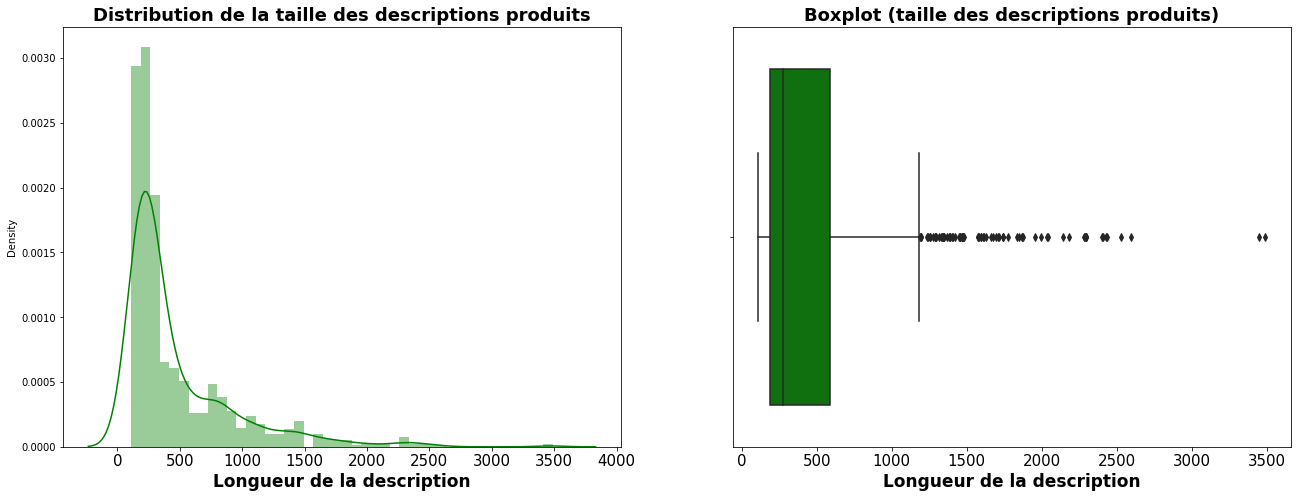

In [25]:
plt.figure(figsize = (22, 17))

plt.subplot(2, 2, 1)
plt.xticks(size = 15)
plt.xlabel('Longueur de la description', weight='bold', size=17)
plt.title('Distribution de la taille des descriptions produits',size = 18, weight = 'bold')
sns.distplot(description_length, color='green')

plt.subplot(2, 2, 2)
plt.xticks(size = 15)
plt.xlabel('Longueur de la description', weight='bold', size=17)
plt.title('Boxplot (taille des descriptions produits)',size = 18, weight = 'bold')
sns.boxplot(description_length, color='green')

In [26]:
#apperçu du description
for i in range(5):
    print('\n# {}. {}\n'.format(i, data['categorie_1'][i]))
    print(data['description'][i])
    print("----------------------" * 5)


# 0. Home Furnishing

Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in

In [27]:
#Convertir tous les caractères majuscules en minuscules
data['description_net'] = data['description'].str.lower()

## Nettoyage des données

In [28]:
#importe toutes les librairies nécessaires :
import nltk
import string
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('words')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [29]:
#initialisation des stopwords et préserver la racine des mots
stopwords = nltk.corpus.stopwords.words('english')
words = set(nltk.corpus.words.words())
lemmatizer = WordNetLemmatizer()


la fonction de preprocessing qui va successivement :
- enlever la ponctuation
- enlever les chiffres
- transformer les phrases en liste de tokens (en liste de mots)
- enlever les stopwords (mots n’apportant pas de sens)
- lemmatizer
- enlever les majuscules
- reformer les phrases avec les mots restants'''


In [30]:
def Preprocess_listofSentence(listofSentence):
 preprocess_list = []
 for sentence in listofSentence :
  sentence_w_punct = "".join([i.lower() for i in sentence if i not in string.punctuation])

  sentence_w_num = ''.join(i for i in sentence_w_punct if not i.isdigit())

  tokenize_sentence = nltk.tokenize.word_tokenize(sentence_w_num)

  words_w_stopwords = [i for i in tokenize_sentence if i not in stopwords]

  words_lemmatize = (lemmatizer.lemmatize(w) for w in words_w_stopwords)

  sentence_clean = ' '.join(w for w in words_lemmatize if w.lower() in words or not w.isalpha())

  preprocess_list.append(sentence_clean)

 return preprocess_list 

In [31]:
  import nltk
  nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [32]:
preprocess_list = Preprocess_listofSentence(data['description_net'])

In [33]:
print('Phrase de base : '+data['description_net'][2])

Phrase de base : key features of eurospa cotton terry face towel set size: small height: 9 inch gsm: 360,eurospa cotton terry face towel set (20 piece face towel set, assorted) price: rs. 299 eurospa brings to you an exclusively designed, 100% soft cotton towels of export quality. all our products have soft texture that takes care of your skin and gives you that enriched feeling you deserve. eurospa has been exporting its bath towels to lot of renowned brands for last 10 years and is famous for its fine prints, absorbency, softness and durability. note: our product is 100% cotton, so it is susceptible to shrinkage. product color may vary from the picture. size may vary by ±3% wash care: wash in cold water, do not iron, do not bleach, flat dry, wash before first use. size- face towel - 23 cms x 23 cms.,specifications of eurospa cotton terry face towel set (20 piece face towel set, assorted) bath towel features material cotton terry design shuvam general brand eurospa gsm 360 type face t

In [34]:
data['description_net'][2]

'key features of eurospa cotton terry face towel set size: small height: 9 inch gsm: 360,eurospa cotton terry face towel set (20 piece face towel set, assorted) price: rs. 299 eurospa brings to you an exclusively designed, 100% soft cotton towels of export quality. all our products have soft texture that takes care of your skin and gives you that enriched feeling you deserve. eurospa has been exporting its bath towels to lot of renowned brands for last 10 years and is famous for its fine prints, absorbency, softness and durability. note: our product is 100% cotton, so it is susceptible to shrinkage. product color may vary from the picture. size may vary by ±3% wash care: wash in cold water, do not iron, do not bleach, flat dry, wash before first use. size- face towel - 23 cms x 23 cms.,specifications of eurospa cotton terry face towel set (20 piece face towel set, assorted) bath towel features material cotton terry design shuvam general brand eurospa gsm 360 type face towel set model n

In [35]:
preprocess_list[2]

'key feature cotton terry face towel set size small height inch cotton terry face towel set piece face towel set assorted price r exclusively designed soft cotton towel export quality product soft texture take care skin give feeling deserve bath towel lot renowned brand last year famous fine print absorbency softness durability note product cotton susceptible shrinkage product color may vary picture size may vary ± wash care wash cold water iron bleach flat dry wash first use size face towel x cotton terry face towel set piece face towel set assorted bath towel feature material cotton terry design general brand type face towel set model name ideal boy girl men woman model id size small color assorted dimension weight g length inch width inch box number content sale package sale package piece face towel set'

In [36]:
print('Phrase nettoyée : '+preprocess_list[2])

Phrase nettoyée : key feature cotton terry face towel set size small height inch cotton terry face towel set piece face towel set assorted price r exclusively designed soft cotton towel export quality product soft texture take care skin give feeling deserve bath towel lot renowned brand last year famous fine print absorbency softness durability note product cotton susceptible shrinkage product color may vary picture size may vary ± wash care wash cold water iron bleach flat dry wash first use size face towel x cotton terry face towel set piece face towel set assorted bath towel feature material cotton terry design general brand type face towel set model name ideal boy girl men woman model id size small color assorted dimension weight g length inch width inch box number content sale package sale package piece face towel set


In [37]:
print('Phrase de base : '+data['description_net'][2])
print('Phrase nettoyée : '+preprocess_list[2])

Phrase de base : key features of eurospa cotton terry face towel set size: small height: 9 inch gsm: 360,eurospa cotton terry face towel set (20 piece face towel set, assorted) price: rs. 299 eurospa brings to you an exclusively designed, 100% soft cotton towels of export quality. all our products have soft texture that takes care of your skin and gives you that enriched feeling you deserve. eurospa has been exporting its bath towels to lot of renowned brands for last 10 years and is famous for its fine prints, absorbency, softness and durability. note: our product is 100% cotton, so it is susceptible to shrinkage. product color may vary from the picture. size may vary by ±3% wash care: wash in cold water, do not iron, do not bleach, flat dry, wash before first use. size- face towel - 23 cms x 23 cms.,specifications of eurospa cotton terry face towel set (20 piece face towel set, assorted) bath towel features material cotton terry design shuvam general brand eurospa gsm 360 type face t

In [38]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


In [39]:
tokenizer = nltk.tokenize.RegexpTokenizer(r'[a-zA-Z]+')


In [40]:
stemmer = nltk.stem.PorterStemmer()
lemmatizer = nltk.wordnet.WordNetLemmatizer()

In [41]:
def CustomTokenizer(str_input) :
    tokens = tokenizer.tokenize(str_input)
    #tokens = [w for w in tokens if not w in list(sw)]
    tokens_stemmed = [stemmer.stem(token) for token in tokens]
    return tokens_stemmed

In [42]:
# Instanciation de l'algorithme TF-IDF

vectorizer = TfidfVectorizer(
    strip_accents= 'ascii',    
    tokenizer = CustomTokenizer
)

X = vectorizer.fit_transform(data['description'])
# X = vectorizer.fit_transform(data['stemmed_better_clean_tokenized_desc'].apply(list_to_string_2))

y = X.toarray()

In [43]:
# Création d'un dataframe avec les résultats

tfidf = pd.DataFrame(y, columns = vectorizer.get_feature_names())

tfidf.head()

,a,aa,aaa,aapno,aari,aarika,abil,abkl,abl,abod,about,abov,abras,abroad,absolut,absorb,abstract,abstrct,ac,accent,access,accessori,accid,accident,accommod,accomplish,accord,acer,ach,aci,acid,acl,acn,across,acryl,act,activ,actual,ad,adaa,adapt,adaptor,add,addict,addit,adf,adhes,adi,adida,adino,...,wrought,ws,wy,x,xa,xbatteri,xbluetooth,xemex,xl,xn,xp,xuser,xyz,y,yardley,yarn,ybscr,ye,year,yellow,yet,yg,ygskb,yiboo,yield,yk,yl,ym,york,you,young,your,yourself,youth,yr,yuva,yve,yx,zaicu,zero,zikrak,zinc,zingalalaa,zip,zipexterior,zipper,zone,zoom,zora,zyxel
0,0.023775,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.152598,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.149257,0.0,0.047722,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.068229,0.000000,0.174116,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.050424,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.032658,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.038273,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.088375,0.0,0.023547,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.042295,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033933,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030167,0.0,0.024113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
# Mot ayant le score TF-IDF maximum par description

tfidf['topic'] = tfidf.apply(lambda row : tfidf.columns[row.argmax()], axis=1)

tfidf['topic']

0        curtain
1           bath
2          towel
3       bedsheet
4          sheet
          ...   
1045        wall
1046         the
1047        film
1048     sticker
1049     uberlyf
Name: topic, Length: 1050, dtype: object

In [45]:
new_top = tfidf['topic'].value_counts().head(7).to_frame()
new_top.style.background_gradient(cmap='Reds')

,topic
to,21
mug,20
skin,12
coffe,12
n,11
dress,9
towel,8


## Fonctions communes

In [46]:
 l_cat = list(set(data['categorie_1']))
print("catégories : ", l_cat)
#y_cat_num = [(1-l_cat.index(data.iloc[i]['categorie_1'])) for i in range(len(data))]

catégories :  ['Baby Care', 'Home Decor', 'Home Furnishing', 'Kitchen', 'Beauty and Personal Care', 'Computers', 'Watches']


In [47]:
from sklearn import preprocessing
y_cat_num = preprocessing.LabelEncoder()
y_cat_num.fit(l_cat)
y_cat_num.transform(l_cat)

array([0, 3, 4, 5, 1, 2, 6])

In [48]:
y_cat_num = [(l_cat.index(data.iloc[i]['categorie_1'])) for i in range(len(data))]

In [49]:
np.unique(y_cat_num)

array([0, 1, 2, 3, 4, 5, 6])

In [50]:
import time
from sklearn import cluster, metrics
from sklearn import manifold, decomposition
# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct(features) :
    time1 = time.time()
    num_labels=len(l_cat)
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, 
                                 init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données après Tsne 
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_tsne, cls.labels_


# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI) :
    fig = plt.figure(figsize=(15,6))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Categorie")
    plt.title('Représentation des tweets par catégories réelles')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des tweets par clusters')
    
    plt.show()
    print("ARI : ", ARI)

# Bag of word - Tf-idf

## Préparation sentences


In [51]:
# création du bag of words (CountVectorizer et Tf-idf)

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cvect = CountVectorizer(stop_words='english', max_df=0.95, min_df=1)
ctf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=1)
feat = 'description_net'
cv_fit = cvect.fit(data[feat])
ctf_fit = ctf.fit(data[feat])

cv_transform = cvect.transform(data[feat])  
ctf_transform = ctf.transform(data[feat])    

## Exécution des modèles

In [52]:
print("CountVectorizer : ")
print("-----------------")
ARI, X_tsne, labels = ARI_fct(cv_transform)
print()
print("Tf-idf : ")
print("--------")
ARI, X_tsne, labels = ARI_fct(ctf_transform)

CountVectorizer : 
-----------------
ARI :  0.3784 time :  11.0

Tf-idf : 
--------
ARI :  0.5567 time :  12.0


## Graphiques

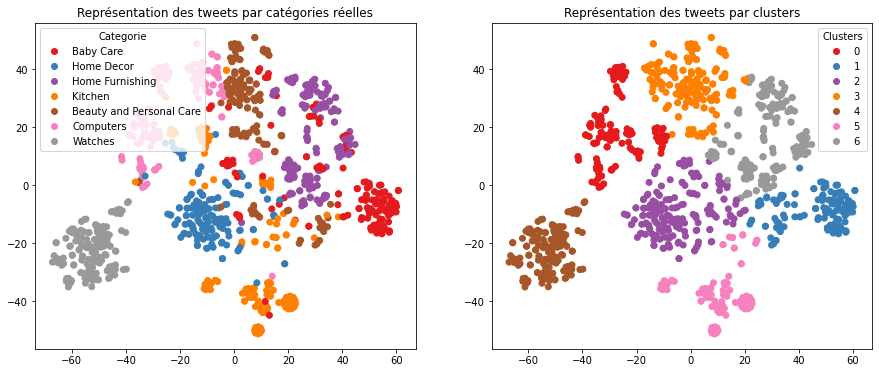

ARI :  0.5567


In [53]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

# Word2Vec

In [54]:
!pip install gensim=='4.1.2'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 2.9 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [55]:
import gensim

In [56]:
print(gensim.__version__)

4.1.2


In [57]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [58]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim

In [59]:
print(tensorflow.__version__)

2.9.2


In [60]:
w2v_size=300
w2v_window=5
w2v_min_count=1
w2v_epochs=100
maxlen = 24 # adapt to length of sentences
sentences = data['description_net'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [61]:
# Création et entraînement du modèle Word2Vec

print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=42,
                                                workers=1)
#                                                workers=multiprocessing.cpu_count())
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 5192
Word2Vec trained


In [62]:
# Préparation des sentences (tokenization)

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen=maxlen,
                                                     padding='post') 
                                                   
num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 5193


In [63]:
# Création de la matrice d'embedding

print("Create Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (5193, 300)


In [64]:
# Création du modèle

input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)

embed_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 24)]              0         
                                                                 
 embedding (Embedding)       (None, 24, 300)           1557900   
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 1,557,900
Trainable params: 1,557,900
Non-trainable params: 0
_________________________________________________________________


In [65]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

33/33 [==============================] - 0s 1ms/step


(1050, 300)

In [66]:
ARI, X_tsne, labels = ARI_fct(embeddings)

ARI :  0.2397 time :  8.0


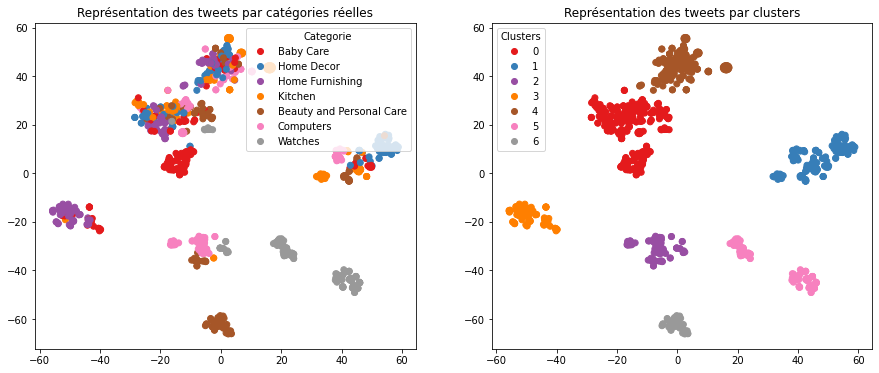

ARI :  0.2397


In [67]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

# BERT

In [68]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 5.2 MB/s 
     |████████████████████████████████| 7.6 MB 43.4 MB/s 
     |████████████████████████████████| 163 kB 63.6 MB/s 


In [69]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 5.2 MB/s 


In [70]:
!pip install transformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [71]:
!pip install tf-nightly-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 543.0 MB 24 kB/s 
     |████████████████████████████████| 6.0 MB 49.8 MB/s 
     |████████████████████████████████| 439 kB 62.0 MB/s 
     |████████████████████████████████| 1.7 MB 54.5 MB/s 
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 requires flatbuffers<2,>=1.12, but you have flatbuffers 22.10.26 which is incompatible.


In [72]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import os
import transformers
from transformers import BertModel, TFBertModel # no attribute 'TFBertModel'
from transformers import BertModel, TFBertModel # good to go

os.environ["TF_KERAS"]='1'

In [73]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.9.2
2.9.2
Num GPUs Available:  1
True


In [74]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

In [75]:
!pip install tensorflow-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 578.0 MB 14 kB/s 
     |████████████████████████████████| 1.7 MB 45.7 MB/s 
     |████████████████████████████████| 5.9 MB 51.5 MB/s 
     |████████████████████████████████| 438 kB 64.1 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of th

In [76]:
import tensorflow_datasets


In [77]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import TFAutoModel
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
sentences = data['description_net'].to_list()

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [78]:
 #Création des features
from transformers import AutoTokenizer, AutoConfig
features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='HF')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

1/1 [==============================] - 0s 28ms/step
temps traitement :  23.0


In [79]:
ARI, X_tsne, labels = ARI_fct(features_bert)

ARI :  0.3478 time :  13.0


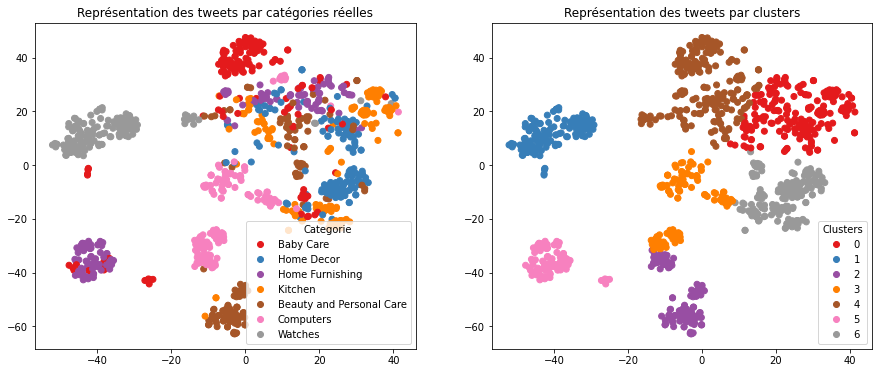

ARI :  0.3478


In [80]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

# USE - Universal Sentence Encoder

In [81]:
!pip install --upgrade tensorflow_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [82]:
!pip install matplotlib-venn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [83]:
!apt-get -qq install -y libfluidsynth1

Selecting previously unselected package libfluidsynth1:amd64.
(Reading database ... 123942 files and directories currently installed.)
Preparing to unpack .../libfluidsynth1_1.1.9-1_amd64.deb ...
Unpacking libfluidsynth1:amd64 (1.1.9-1) ...
Setting up libfluidsynth1:amd64 (1.1.9-1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.6) ...


In [84]:
!apt-get -qq install -y libarchive-dev && pip install -U libarchive
import libarchive

Selecting previously unselected package libarchive-dev:amd64.
(Reading database ... 123947 files and directories currently installed.)
Preparing to unpack .../libarchive-dev_3.2.2-3.1ubuntu0.7_amd64.deb ...
Unpacking libarchive-dev:amd64 (3.2.2-3.1ubuntu0.7) ...
Setting up libarchive-dev:amd64 (3.2.2-3.1ubuntu0.7) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 154 kB 7.6 MB/s 
  Created wheel for libarchive: filename=libarchive-0.4.7-py3-none-any.whl size=31646 sha256=a8da2b3a46c0e55169562bf489d9055377777cee08dbb40092edd02316916ed3
  Stored in directory: /root/.cache/pip/wheels/63/b1/c6/b3da79bec2012175bd43603eed98ef8548ac1733b77c1d4330
Successfully built libarchive


In [85]:
!apt-get -qq install -y graphviz && pip install pydot
import pydot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [86]:
!pip install cartopy
import cartopy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 10.8 MB 5.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 27.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 42.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 40.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 12.1 MB 41.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 46 kB 4.2 MB/s 
  Created wheel for cartopy: filename=Cartopy-0.19.0.post1-cp37-cp37m

In [87]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 5.1 MB/s 
     |████████████████████████████████| 438 kB 50.9 MB/s 
     |████████████████████████████████| 5.8 MB 62.4 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.10.0
    Uninstalling tensorflow-estimator-2.10.0:
      Successfully uninstalled tensorflow-estimator-2.10.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.10.1
    Uninstalling tensorboard-2.10.1:
      Successfully uninstalled tensorboard-2.10.1
  Attempting uninstall: keras
    Found existing installation: keras 2.10.0
    Uninstalling keras-2.10.0:
      Successfully uninstalled keras-2.10.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 22.10.26
    Uninstalling flatbuffers-22.10.26:
      Successfully uninstalled flatbuffers-22.10.26
ERROR: pip

In [88]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.models import Model

# Bert
import transformers

os.environ["TF_KERAS"]='1'

In [89]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.9.2
2.9.2
Num GPUs Available:  1
True


In [90]:
!pip install matplotlib-venn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [91]:
!apt-get -qq install -y libfluidsynth1

In [92]:
!apt-get -qq install -y libarchive-dev && pip install -U libarchive
import libarchive

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [93]:
!apt-get -qq install -y graphviz && pip install pydot
import pydot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [94]:
!pip install cartopy
import cartopy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [95]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [96]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

In [97]:
from torchvision import transforms
batch_size = 10
sentences = data['description_net'].to_list()

In [98]:
features_USE = feature_USE_fct(sentences, batch_size)

In [99]:
ARI, X_tsne, labels = ARI_fct(features_USE)

ARI :  0.4493 time :  38.0


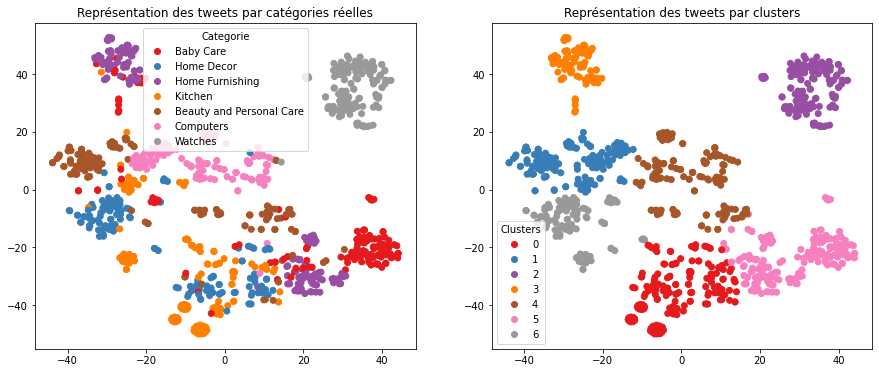

ARI :  0.4493


In [100]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)